In [3]:
folder_path = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/total_scenario/old-form-all")

hourly_totals = []

for file in sorted(folder_path.glob("od_matrix_*.txt")):
    match = re.search(r"od_matrix_(\d+)\.txt", file.name)
    if not match:
        continue
    hour = int(match.group(1))

    with open(file, "r", encoding="utf-8") as f:
        lines = f.readlines()[3:]

    total_trips = sum(int(line.strip().split()[-1]) for line in lines if line.strip())

    hourly_totals.append({"hour": f"{hour:02d}:00-{hour+1:02d}:00", "total_trips": total_trips})

df = pd.DataFrame(hourly_totals)
output_path = "/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/total_scenario/statistics/hourly_trip_counts.csv"
df.to_csv(output_path, index=False)


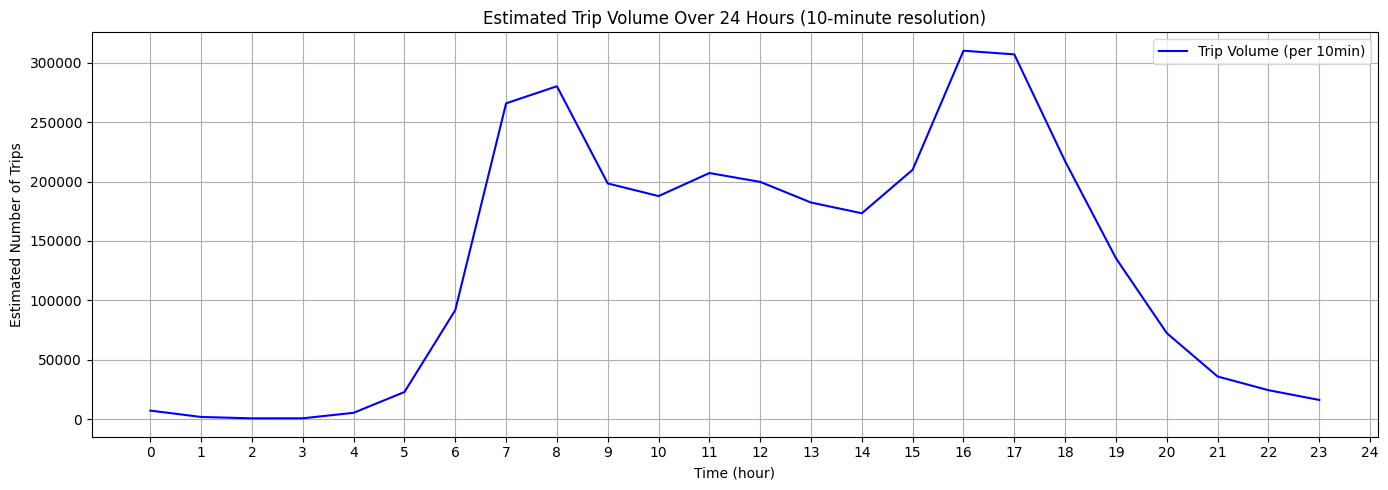

In [7]:
units_per_hour = 1
minutes_per_unit = 60 / units_per_hour

expanded_hours = []
expanded_trips = []

for i in range(len(df)):
    hour_start = i
    hour_end = i + 1
    trip_count = df.loc[i, "total_trips"]
    
    for j in range(units_per_hour):
        t = hour_start + j / units_per_hour
        expanded_hours.append(t)
        expanded_trips.append(trip_count / units_per_hour)

plt.figure(figsize=(14, 5))
plt.plot(expanded_hours, expanded_trips, label="Trip Volume (per 10min)", color="blue")
plt.xlabel("Time (hour)")
plt.ylabel("Estimated Number of Trips")
plt.title("Estimated Trip Volume Over 24 Hours (10-minute resolution)")
plt.grid(True)
plt.xticks(np.arange(0, 25, 1))
plt.tight_layout()
plt.legend()
plt.show()

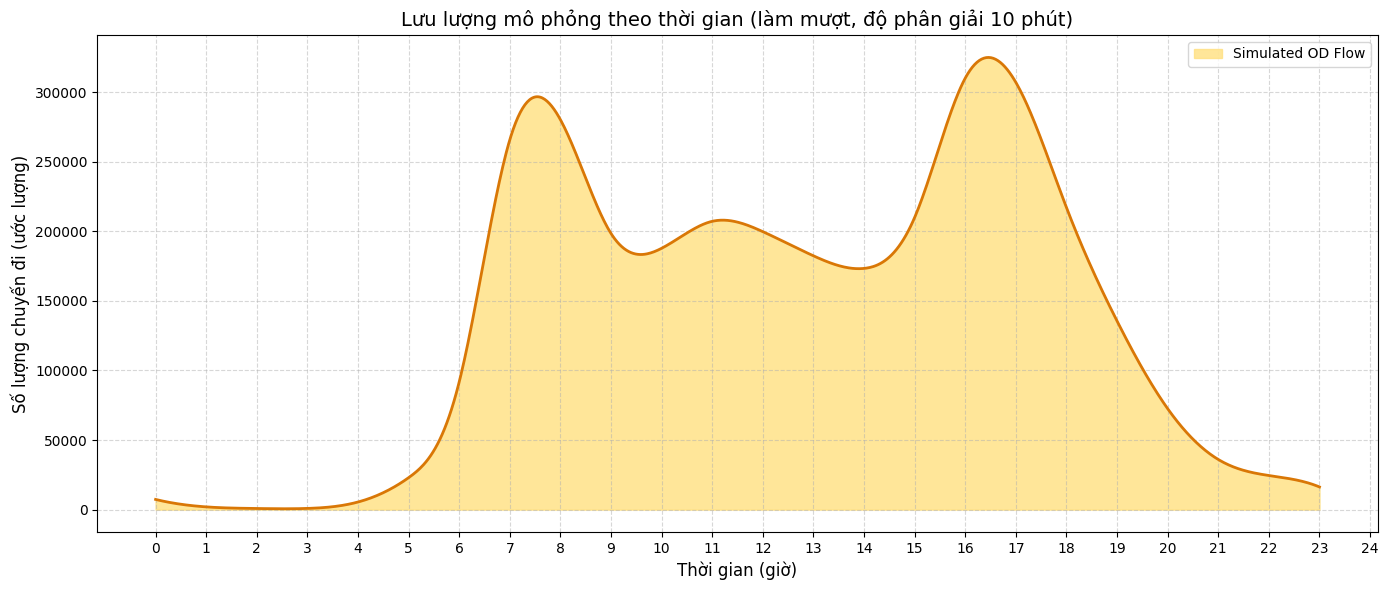

In [13]:
# Nạp lại dữ liệu từ file CSV đã sinh trước đó
import pandas as pd
from pathlib import Path

output_path
df = pd.read_csv(output_path)

units_per_hour = 1
expanded_hours = []
expanded_trips = []

for i in range(len(df)):
    hour_start = i
    trip_count = df.loc[i, "total_trips"]
    for j in range(units_per_hour):
        t = hour_start + j / units_per_hour
        expanded_hours.append(t)
        expanded_trips.append(trip_count / units_per_hour)

# Nội suy spline mượt
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

x = np.array(expanded_hours)
y = np.array(expanded_trips)

spline = make_interp_spline(x, y, k=3)
x_smooth = np.linspace(x.min(), x.max(), 1000)
y_smooth = spline(x_smooth)

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.fill_between(x_smooth, y_smooth, color="#FFE080", alpha=0.8, label="Simulated OD Flow")
plt.plot(x_smooth, y_smooth, color="#D97706", linewidth=2)

plt.title("Lưu lượng mô phỏng theo thời gian (làm mượt, độ phân giải 10 phút)", fontsize=14)
plt.xlabel("Thời gian (giờ)", fontsize=12)
plt.ylabel("Số lượng chuyến đi (ước lượng)", fontsize=12)
plt.xticks(np.arange(0, 25, 1))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import plotly.express as px

# 1. Đọc và xử lý dữ liệu như trước
base_dir = "/home/hoai-linh.dao/Works/EVCS/EV-Simulations/experiments/AMP-060725-all-meso-2/simulation/outputs"
records = []
for hour_dir in sorted(os.listdir(base_dir)):
    if not hour_dir.startswith("hour_"): continue
    path = os.path.join(base_dir, hour_dir, "summary.xml")
    if not os.path.isfile(path): continue
    tree = ET.parse(path)
    times, inserted = [], []
    for step in tree.getroot().findall("step"):
        times.append(int(float(step.get("time"))))
        inserted.append(int(step.get("inserted")))
    order = np.argsort(times)
    times = np.array(times)[order]
    inserted = np.array(inserted)[order]
    deltas = np.diff(inserted, prepend=0)
    records.extend(zip(times, deltas))

df = pd.DataFrame(records, columns=["t", "delta_I"]).groupby("t", as_index=False).sum()
max_t = df["t"].max()
all_secs = pd.DataFrame({"delta_I": np.zeros(max_t+1, int)}, index=np.arange(max_t+1))
all_secs.loc[df["t"], "delta_I"] = df["delta_I"].values

# Gaussian smoothing
sigma = 60
smoothed = gaussian_filter1d(all_secs["delta_I"].values, sigma=sigma)
smoothed = np.clip(smoothed, 0, None)

# 2. Tạo DataFrame cho Plotly
hours = all_secs.index / 3600.0
df_plot = pd.DataFrame({"Giờ": hours, "Số chuyến (mịn)": smoothed})

# 3. Vẽ biểu đồ tương tác
fig = px.line(df_plot, x="Giờ", y="Số chuyến (mịn)", labels={"Giờ": "Giờ trong ngày", "Số chuyến (mịn)": "Số xe khởi hành"})
fig.update_traces(hovertemplate="Giờ: %{x:.2f}<br>Số xe: %{y:.0f}<extra></extra>")
fig.update_layout(xaxis=dict(tickmode="array", tickvals=list(range(0,25,2))), title=f"Khởi hành theo giây (Gaussian σ={sigma})")
fig.show()


